In [1]:
from bs4 import BeautifulSoup
from shapely.geometry import Polygon

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Import and Parse XML

In [2]:
water_hyacinths_rgb = []
garbages_rgb = []

In [3]:
images = []
files = [
    './segmentations/batch1.xml', 
    './segmentations/batch2.xml', 
    './segmentations/batch3.xml', 
    './segmentations/batch4.xml'
]
for file in files:
    with open(file, 'r') as f:
        soup = BeautifulSoup(f.read(), "xml")
        for img in soup.find_all('image'):
            image = cv2.imread('./images/images/%s' % img['name'], cv2.IMREAD_COLOR)
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            hsv_image = cv2.resize(hsv_image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
            image = cv2.resize(image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
            scale_x, scale_y = int(img['height']) / 360, int(img['width']) / 640
            
            water_hyacinths = 0

            height = int(img.get('height'))
            width = int(img.get('width'))
            rivers = []
            water_hyacinths = []
            water_hyacinth_bounds = []
            garbage = []
            garbage_bounds = []
            boats = []
            others = []
            too_small = 0
            total = 0

            for polygon in img.find_all('polygon'):
                mask = np.zeros((360, 640))
                
                if(polygon.get('label') == 'river'):
                    coords = [[float(p.split(',')[0]) / scale_x, float(p.split(',')[1]) / scale_y] for p in polygon.get('points').split(';')]
                    poly = Polygon(coords)
                    
                    rivers.append(poly.area)
                elif(polygon.get('label') == 'object'):
                    coords = [[round(float(p.split(',')[0]) / scale_x), round(float(p.split(',')[1]) / scale_y)] for p in polygon.get('points').split(';')]
                    poly = Polygon(coords)
                    
                    cv2.drawContours(mask, np.array([coords]), -1, 1, -1, cv2.LINE_AA)
                    
                    if(poly.area < 25):
                        too_small += 1
                    total += 1
                    
                    if(polygon.find('attribute').text == 'water hyacinth'):
                        water_hyacinths.append('%.2f' % poly.area)
                        water_hyacinth_bounds.append(','.join(['%.2f' % point for point in poly.bounds]))
                        
                        total_red = 0
                        total_green = 0
                        total_blue = 0
                        count = 0
                        for tup in zip(np.where(mask==1)[0], np.where(mask==1)[1]):
                            total_red += image[tup][0]
                            total_green += image[tup][1]
                            total_blue += image[tup][2]
                            count += 1
                            water_hyacinths_rgb.append({'red': image[tup][0], 'green': image[tup][1], 'blue': image[tup][2], 'hue': hsv_image[tup][0], 'saturation': hsv_image[tup][1], 'value': hsv_image[tup][2]})
                        try:
                            water_hyacinths_obj_rgb.append({'red': total_red / count, 'green': total_green / count, 'blue': total_blue / count})
                        except:
                            pass
                    elif(polygon.find('attribute').text == 'garbage'):
                        garbage.append('%.2f' % poly.area)
                        garbage_bounds.append(','.join(['%.2f' % point for point in poly.bounds]))
                        
                        total_red = 0
                        total_green = 0
                        total_blue = 0
                        count = 0
                        for tup in zip(np.where(mask==1)[0], np.where(mask==1)[1]):
                            total_red += image[tup][0]
                            total_green += image[tup][1]
                            total_blue += image[tup][2]
                            count += 1
                            garbages_rgb.append({'red': image[tup][0], 'green': image[tup][1], 'blue': image[tup][2], 'hue': hsv_image[tup][0], 'saturation': hsv_image[tup][1], 'value': hsv_image[tup][2]})
                        try:
                            garbages_obj_rgb.append({'red': total_red / count, 'green': total_green / count, 'blue': total_blue / count})
                        except:
                            pass
                    elif(polygon.find('attribute').text == 'boat'):
                        boats.append('%.2f' % poly.area)
                    elif(polygon.find('attribute').text == 'others'):
                        others.append('%.2f' % poly.area)
            
            if(too_small > 0):
                print('%s has %d/%d objects smaller than 25 pixel area' % (img['id'], too_small, total))
            if(len(rivers) > 1):
                print('%s has more than 1 river segment' % img['id'])
            river_area = sum(rivers)
            
            images.append({
                'name': img.get('name'),
                'height': height,
                'width': width,
                'river_relative_to_image': river_area / (640 * 360) if river_area else None,
                'water_hyacinths': ','.join(water_hyacinths),
                'water_hyacinth_bounds': '|'.join(water_hyacinth_bounds),
                'wh_count': len(water_hyacinths),
                'garbage': ','.join(garbage),
                'garbage_bounds': '|'.join(garbage_bounds),
                'g_count': len(garbage),
                'boats': ','.join(boats),
                'b_count': len(boats),
                'others': ','.join(others),
                'o_count': len(others),
            })

0 has 5/8 objects smaller than 25 pixel area
1 has 1/4 objects smaller than 25 pixel area
2 has 6/8 objects smaller than 25 pixel area
2 has more than 1 river segment
3 has 3/3 objects smaller than 25 pixel area
4 has 1/1 objects smaller than 25 pixel area
5 has 6/8 objects smaller than 25 pixel area
6 has 2/3 objects smaller than 25 pixel area
7 has 1/3 objects smaller than 25 pixel area
8 has 164/206 objects smaller than 25 pixel area
9 has 1/5 objects smaller than 25 pixel area
10 has 1/1 objects smaller than 25 pixel area
11 has 3/5 objects smaller than 25 pixel area
12 has 4/6 objects smaller than 25 pixel area
13 has 5/12 objects smaller than 25 pixel area
15 has 2/5 objects smaller than 25 pixel area
16 has 7/21 objects smaller than 25 pixel area
17 has 2/3 objects smaller than 25 pixel area
17 has more than 1 river segment
18 has 1/2 objects smaller than 25 pixel area
20 has 1/3 objects smaller than 25 pixel area
22 has 6/9 objects smaller than 25 pixel area
23 has 5/15 objects

80 has 12/14 objects smaller than 25 pixel area
81 has 8/18 objects smaller than 25 pixel area
83 has 2/3 objects smaller than 25 pixel area
84 has 10/12 objects smaller than 25 pixel area
86 has 12/13 objects smaller than 25 pixel area
88 has 1/3 objects smaller than 25 pixel area
89 has 4/6 objects smaller than 25 pixel area
90 has 1/2 objects smaller than 25 pixel area
91 has 6/14 objects smaller than 25 pixel area
92 has 8/9 objects smaller than 25 pixel area
94 has 3/6 objects smaller than 25 pixel area
0 has 16/28 objects smaller than 25 pixel area
1 has 17/34 objects smaller than 25 pixel area
2 has 2/2 objects smaller than 25 pixel area
4 has 1/1 objects smaller than 25 pixel area
5 has 4/7 objects smaller than 25 pixel area
6 has 3/5 objects smaller than 25 pixel area
7 has 1/1 objects smaller than 25 pixel area
8 has 5/7 objects smaller than 25 pixel area
9 has 1/3 objects smaller than 25 pixel area
10 has 23/27 objects smaller than 25 pixel area
11 has more than 1 river segm

## Convert JSON to Pandas DataFrame

In [4]:
df = pd.DataFrame(images)

df.head()

,name,height,width,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,garbage_bounds,g_count,boats,b_count,others,o_count
0,098a1d68568bc.jpg,2250,4000,0.789922,"28.00,17.00,5.00,40.00,19.50,57.50","195.00,77.00,206.00,82.00|78.00,109.00,84.00,1...",6,12.00,"65.00,110.00,72.00,113.00",1,,0,4.00,1
1,0bcf8ec7197b6.jpg,2250,4000,0.583218,"85.50,92.50","396.00,161.00,422.00,167.00|70.00,133.00,96.00...",2,"11.00,56.50","465.00,252.00,473.00,257.00|312.00,223.00,325....",2,,0,,0
2,10b9ed1b6f7a1.jpg,6000,8000,0.687522,"14.50,41.00,4.50,2.00,16.50,9.00,49886.00","105.00,147.00,112.00,152.00|239.00,131.00,265....",7,14.00,"31.00,255.00,38.00,262.00",1,,0,,0
3,1488a698e63bd.jpg,2250,4000,0.759801,"18.00,20.00,24.00","232.00,123.00,239.00,128.00|579.00,113.00,586....",3,,,0,,0,,0
4,154f0cb77c45e.jpg,2250,4000,0.836265,10.00,"558.00,64.00,564.00,66.00",1,,,0,,0,,0


In [5]:
df.to_json('annotation_statistics.json', orient='records')

## Import Data

In [6]:
combined_df = pd.merge(pd.read_json('./segmentations/annotation_statistics.json'), pd.read_json('./image_metadatas/metadatas.json'), left_on='name', right_on='filename')

combined_df = combined_df.drop(['_id', 'filename', 'alpha', 'beta', 'gamma', '__v', 'compass'], axis=1)
combined_df['longitude'] = combined_df['longitude'].apply(lambda x: float(x['$numberDecimal']))
combined_df['latitude'] = combined_df['latitude'].apply(lambda x: float(x['$numberDecimal']))

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   name                     360 non-null    object             
 1   height                   360 non-null    int64              
 2   width                    360 non-null    int64              
 3   area                     360 non-null    int64              
 4   river_area               360 non-null    float64            
 5   river_relative_to_image  360 non-null    float64            
 6   water_hyacinths          360 non-null    object             
 7   water_hyacinth_bounds    360 non-null    object             
 8   wh_count                 360 non-null    int64              
 9   garbage                  360 non-null    object             
 10  garbage_bounds           360 non-null    object             
 11  g_count                  360 non

In [7]:
combined_df.head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,g_count,boats,b_count,others,o_count,description,weather,datetime,longitude,latitude
0,098a1d68568bc.jpg,2250,4000,9000000,7.109300e+06,0.789922,"1601.45,700.06,2158.59,212.82,988.12,702.63","2248.29,505.18,2328.55,543.52|262.39,481.43,30...",6,"450.63,112.58",...,2,,0,161.35,1,Near Estrella Pantaleon Bridge,Sunny,2023-01-11 02:55:44.915000+00:00,121.038998,14.567429
1,0bcf8ec7197b6.jpg,2250,4000,9000000,5.248960e+06,0.583218,"3491.98,3261.25","436.94,834.35,599.95,871.16|2475.63,1007.40,26...",2,"250.78,2111.14,372.59",...,3,,0,,0,Near Rockwell along walkway,Cloudy,2023-01-05 02:41:12.626000+00:00,121.037243,14.566365
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,1,,0,,0,Riverbank,Sunny,2022-12-29 08:06:58.970000+00:00,120.977622,14.596740
3,1488a698e63bd.jpg,2250,4000,9000000,6.838209e+06,0.759801,"833.01,673.73,731.12","3808.70,726.13,3859.95,754.70|1448.01,768.40,1...",3,,...,0,,0,,0,Near Guadalupe Bridge,Sunny,2023-01-11 02:35:44.059000+00:00,121.044888,14.568310
4,154f0cb77c45e.jpg,2250,4000,9000000,7.526385e+06,0.836265,"492.94,222.14","3486.60,397.46,3523.62,415.46|1356.79,467.61,1...",2,,...,0,,0,,0,Along JP Rizal Ave.,Sunny,2023-01-11 04:17:53.536000+00:00,121.039207,14.567435


## Validation

### Check how images have missing rivers

In [8]:
combined_df[combined_df['river_area'] != combined_df['river_area']]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,g_count,boats,b_count,others,o_count,description,weather,datetime,longitude,latitude


### Check how many rivers have less than 50% area of the image

In [9]:
combined_df[combined_df['river_relative_to_image'] < 0.5]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,g_count,boats,b_count,others,o_count,description,weather,datetime,longitude,latitude
19,3cee913a8e627.jpg,2250,4000,9000000,4.246180e+06,0.471798,"1759.92,1982.69,965.80,4480.71,14368.37,4176.6...","747.32,953.99,833.50,980.37|438.51,963.99,572....",7,,...,0,,0,,0,Near Rockwell along walkway,Cloudy,2023-01-05 02:55:04.662000+00:00,121.037097,14.566885
55,a45229c7ea87c.jpg,2250,4000,9000000,4.175424e+06,0.463936,"897.59,3241.72,655.84,1157.77,35160.09","2226.23,1087.31,2282.72,1115.81|2261.35,991.63...",5,,...,0,,0,,0,Near Rockwell along walkway,Cloudy,2023-01-05 02:39:10.487000+00:00,121.036355,14.566675
174,0809051412264.jpg,1440,2560,3686400,1.821153e+06,0.494019,"85.59,339.21,432.98","981.62,643.34,994.25,651.63|1103.95,630.52,115...",3,"40.93,803.85",...,2,,0,,0,Riverbank Binondo-Intramuros Bridge,Cloudy,2023-02-06 05:18:59.342000+00:00,120.974545,14.596326
219,c9f4e5978eeab.jpg,1440,2560,3686400,1.746068e+06,0.473651,"163.34,284.85,82.32,264.64,704.98","1171.05,938.64,1199.73,950.03|1329.00,750.00,1...",5,"146.37,414.50,1319.93,118.88",...,4,,0,,0,Riverbank - Yuchenco Park,Cloudy,2023-02-06 05:38:31.153000+00:00,120.977221,14.595985
239,e3bf24cb929d4.jpg,1440,2560,3686400,1.705196e+06,0.462564,"3340.90,308.75,137.01,319.09,124.73,986.46,929...","2288.91,1194.63,2397.26,1253.26|631.40,832.92,...",16,"661.64,286.17,49.79,119.83,148.03,1587.96",...,6,,0,,0,Riverbank - Yuchenco Park,Cloudy,2023-02-06 05:39:03.289000+00:00,120.977790,14.596348
356,9bbf5b63e91e4.jpg,1440,2560,3686400,1.617173e+06,0.438686,"501.39,199.73,40.75,1058.42,530.19,55.93,684.8...","1380.24,838.03,1435.69,859.08|966.33,847.56,98...",18,"326.76,112.01,298.95,291.15",...,4,38925.27,1,,0,Riverbank - Yuchenco Park,Cloudy,2023-02-06 05:39:32.790000+00:00,120.977847,14.596531


## Analysis and Visualization

### Visualize the number of images per image resolution

In [10]:
combined_df['resolution'] = combined_df.apply(lambda x: '%dx%d' % (x['height'], x['width']), axis=1)

Text(0.5, 1.0, 'Number of Images per Resolution')

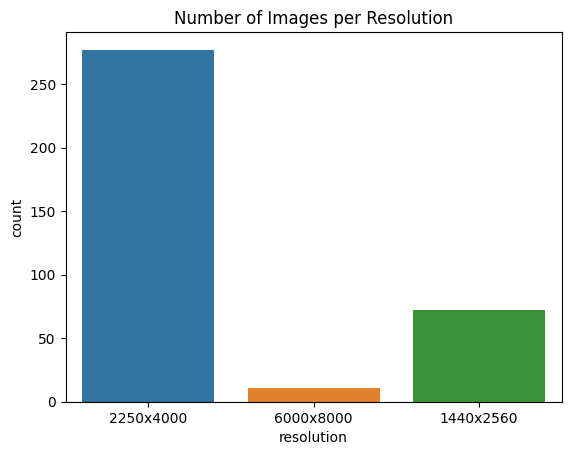

In [11]:
sns.countplot(combined_df, x='resolution')

plt.title('Number of Images per Resolution')

### Amount of Objects per Image

In [12]:
combined_df['n_objects'] = combined_df.apply(lambda x: x['wh_count'] + x['g_count'] + x['b_count'] + x['o_count'], axis=1)

Text(0.5, 1.0, 'Distribution of Objects found per Image')

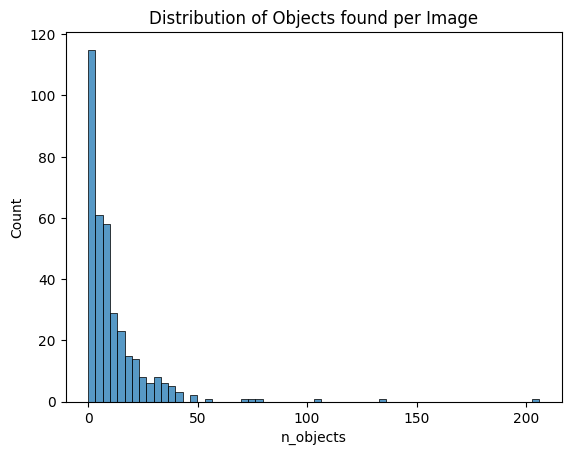

In [13]:
sns.histplot(combined_df, x='n_objects')

plt.title('Distribution of Objects found per Image')

###  Objects Found

In [14]:
def check_objects_found(row):
    found = []
    if(row['wh_count'] > 0):
        found.append('wh')
    if(row['g_count'] > 0):
        found.append('g')
    if(row['b_count'] > 0):
        found.append('b')
    if(row['o_count'] > 0):
        found.append('o')
    return '+'.join(found) if (len(found) > 0) else "none"

combined_df['objects_found'] = combined_df.apply(lambda x: check_objects_found(x), axis=1)

Text(0.5, 1.0, 'Number of Images with Corresponding Objects')

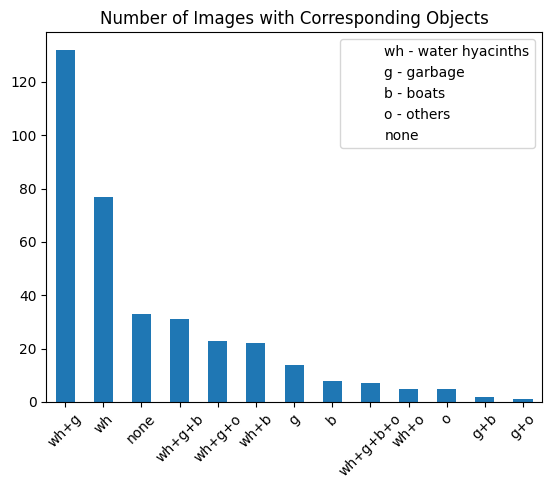

In [15]:
combined_df['objects_found'].value_counts().plot(kind='bar')

plt.legend(handles=[mpatches.Patch(color='white', label='wh - water hyacinths'),
                   mpatches.Patch(color='white', label='g - garbage'),
                   mpatches.Patch(color='white', label='b - boats'),
                   mpatches.Patch(color='white', label='o - others'),
                   mpatches.Patch(color='white', label='none')])
plt.xticks(rotation=45)

plt.title("Number of Images with Corresponding Objects")

In [18]:
counts = {
    'water hyacinths': combined_df['objects_found'].apply(lambda x: 'wh' in x).sum(),
    'garbages': combined_df['objects_found'].apply(lambda x: 'g' in x).sum(),
    'others': combined_df['objects_found'].apply(lambda x: 'o' in x).sum(),
    'boats': combined_df['objects_found'].apply(lambda x: 'b' in x).sum(),
    'none': combined_df['objects_found'].apply(lambda x: 'none' == x).sum(),
}

counts

{'water hyacinths': 297,
 'garbages': 210,
 'others': 74,
 'boats': 70,
 'none': 33}

Text(0.5, 0, 'Object Name')

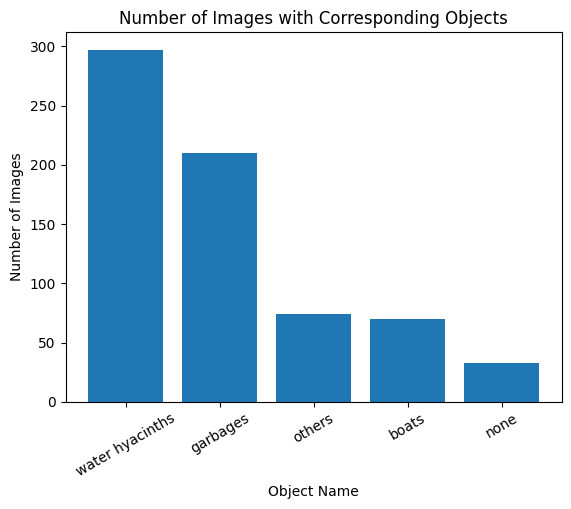

In [19]:
plt.bar(counts.keys(), counts.values())

plt.xticks(rotation=30)
plt.title('Number of Images with Corresponding Objects')
plt.ylabel('Number of Images')
plt.xlabel('Object Name')

### River Coverage

Text(0.5, 1.0, 'Distribution of River Coverage')

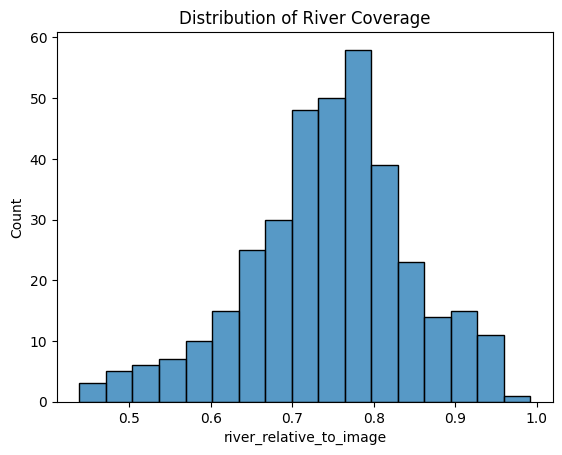

In [17]:
sns.histplot(combined_df, x='river_relative_to_image')

plt.title("Distribution of River Coverage")

In [18]:
combined_df['total_wh'] = combined_df['water_hyacinths'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
combined_df['total_g'] = combined_df['garbage'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
combined_df['total_b'] = combined_df['boats'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))
combined_df['total_o'] = combined_df['others'].apply(lambda x: sum([float(val) for val in x.split(',') if val != '']))

In [19]:
combined_df['wh_relative_to_river'] = combined_df['total_wh'] / combined_df['river_area']
combined_df['g_relative_to_river'] = combined_df['total_g'] / combined_df['river_area']
combined_df['b_relative_to_river'] = combined_df['total_b'] / combined_df['river_area']
combined_df['o_relative_to_river'] = combined_df['total_o'] / combined_df['river_area']

In [20]:
combined_df[['wh_relative_to_river', 'g_relative_to_river', 'b_relative_to_river', 'o_relative_to_river']].describe()

,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
count,360.000000,360.000000,360.000000,360.000000
mean,0.005654,0.000401,0.009417,0.000071
std,0.026629,0.001129,0.046584,0.000812
min,0.000000,0.000000,0.000000,0.000000
25%,0.000161,0.000000,0.000000,0.000000
50%,0.000651,0.000043,0.000000,0.000000
75%,0.002422,0.000234,0.000000,0.000000
max,0.315565,0.011233,0.499499,0.014995


In [21]:
combined_df.head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
0,098a1d68568bc.jpg,2250,4000,9000000,7.109300e+06,0.789922,"1601.45,700.06,2158.59,212.82,988.12,702.63","2248.29,505.18,2328.55,543.52|262.39,481.43,30...",6,"450.63,112.58",...,9,wh+g+o,6363.67,563.21,0.0,161.35,0.000895,0.000079,0.0,0.000023
1,0bcf8ec7197b6.jpg,2250,4000,9000000,5.248960e+06,0.583218,"3491.98,3261.25","436.94,834.35,599.95,871.16|2475.63,1007.40,26...",2,"250.78,2111.14,372.59",...,5,wh+g,6753.23,2734.51,0.0,0.00,0.001287,0.000521,0.0,0.000000
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,8,wh+g,10413985.19,1904.18,0.0,0.00,0.315565,0.000058,0.0,0.000000
3,1488a698e63bd.jpg,2250,4000,9000000,6.838209e+06,0.759801,"833.01,673.73,731.12","3808.70,726.13,3859.95,754.70|1448.01,768.40,1...",3,,...,3,wh,2237.86,0.00,0.0,0.00,0.000327,0.000000,0.0,0.000000
4,154f0cb77c45e.jpg,2250,4000,9000000,7.526385e+06,0.836265,"492.94,222.14","3486.60,397.46,3523.62,415.46|1356.79,467.61,1...",2,,...,2,wh,715.08,0.00,0.0,0.00,0.000095,0.000000,0.0,0.000000


In [22]:
combined_df.sort_values('wh_relative_to_river', ascending=False).head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,3.300106e+07,0.687522,"504.41,10393862.49,3545.15,9387.88,1263.40,303...","1788.27,1903.47,1838.92,1937.82|3285.56,2639.7...",7,1904.18,...,8,wh+g,10413985.19,1904.18,0.00,0.0,0.315565,0.000058,0.000000,0.0
168,f43bb3ac63ddf.jpg,2250,4000,9000000,4.608956e+06,0.512106,"3300.46,240.23,1049996.84,168.37,246.05,27.12,...","2184.47,1878.37,2289.87,1931.81|3078.19,1115.5...",14,"4023.56,532.42,200.80,470.72,904.72,719.11,117...",...,38,wh+g+b,1189099.10,36525.96,1003540.80,0.0,0.257997,0.007925,0.217737,0.0
148,b898834e0c802.jpg,2250,4000,9000000,7.202757e+06,0.800306,"151.08,765323.54,528492.14,770.38","2487.97,394.53,2513.04,402.19|460.55,1538.69,2...",4,"935.84,7239.49,2240.84,711.84,12126.47,2149.16...",...,16,wh+g,1294737.14,39423.07,0.00,0.0,0.179756,0.005473,0.000000,0.0
105,6660bfd083303.jpg,2250,4000,9000000,5.828242e+06,0.647582,"715447.31,424.65,1082.37,265.43,222.98,1275.04...","1330.82,616.47,3196.72,1344.74|2971.67,1118.92...",17,"121.75,391.16,176.15,913.32,427.28,484.28,253....",...,47,wh+g+b,975941.85,22869.57,738074.03,0.0,0.167450,0.003924,0.126638,0.0
163,dd84333a1a776.jpg,2250,4000,9000000,7.331914e+06,0.814657,"136.30,658388.71,172.49,170.94,3411.93,364.21,...","975.38,1822.82,988.10,1836.61|0.00,1706.77,195...",16,"1080.67,12234.33,18102.13,2176.88,1498.64,622....",...,27,wh+g,1089247.23,49819.93,0.00,0.0,0.148562,0.006795,0.000000,0.0


In [23]:
combined_df[combined_df['b_relative_to_river'] > 0.4]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
51,9af65325b6362.jpg,2250,4000,9000000,4.531375e+06,0.503486,"11300.88,388.40,14127.45,709.62,517.65","3631.78,532.06,3897.09,585.56|2332.83,720.98,2...",5,,...,6,wh+b,27044.00,0.00,2263417.57,0.0,0.005968,0.000000,0.499499,0.0
169,f4bd2f7908857.jpg,2250,4000,9000000,6.920845e+06,0.768983,"142362.68,109345.05","0.00,1514.81,766.54,1918.38|909.82,1835.85,177...",2,1124.27,...,4,wh+g+b,251707.73,1124.27,3301857.84,0.0,0.036370,0.000162,0.477089,0.0


### Image with most water hyacinths

In [24]:
top_5_most_water_hyacinths = combined_df['water_hyacinths'].apply(lambda x: len(x.split(','))).sort_values(ascending=False).head(5).index
combined_df.iloc[top_5_most_water_hyacinths]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,water_hyacinth_bounds,wh_count,garbage,...,n_objects,objects_found,total_wh,total_g,total_b,total_o,wh_relative_to_river,g_relative_to_river,b_relative_to_river,o_relative_to_river
8,1eb0743881e5f.jpg,2250,4000,9000000,8.929242e+06,0.992138,"1177.14,412.20,173.56,95.88,733.75,331.19,135....","1425.51,1116.75,1489.36,1159.57|1323.01,768.85...",205,1334.59,...,206,wh+g,149447.48,1334.59,0.00,0.00,0.016737,0.000149,0.000000,0.000000
330,66fd99b75f6c7.jpg,1440,2560,3686400,2.628849e+06,0.713121,"543.57,7.55,11.11,65.22,25.46,15.99,10.68,41.8...","974.50,594.64,1029.79,621.05|1122.47,613.34,11...",68,"35.40,57.30,33.28,37.54,112.40,194.99,28.81,16...",...,106,wh+g+b,13294.64,1900.76,9989.08,0.00,0.005057,0.000723,0.003800,0.000000
135,9a51bf2d4ae.jpg,2250,4000,9000000,6.561411e+06,0.729046,"3691.36,21892.45,110.44,933.66,124.79,288.42,8...","3763.84,2171.94,3970.45,2206.30|0.00,1968.21,2...",63,"315.44,5993.83,1935.11,729.52,7365.70,246.40,2...",...,74,wh+g,102901.03,73704.16,0.00,0.00,0.015683,0.011233,0.000000,0.000000
280,1cfecac9fd128.jpg,1440,2560,3686400,2.544791e+06,0.690319,"4563.77,2543.15,1601.18,524.74,165.11,3132.00,...","799.63,1010.27,1056.39,1075.42|125.95,1024.41,...",38,"56.72,202.31,220.93,274.94,148.27,498.41,188.8...",...,78,wh+g+b+o,33511.68,9326.46,215.36,551.74,0.013169,0.003665,0.000085,0.000217
319,5a1655525eb37.jpg,2250,4000,9000000,6.801088e+06,0.755676,"121.80,750.73,153.14,174.42,294.59,291.18,95.0...","721.05,526.75,744.24,537.55|2935.16,676.52,299...",36,"537.52,40.22,117.98,52.45,324.61,47.32",...,42,wh+g,23072.73,1120.10,0.00,0.00,0.003393,0.000165,0.000000,0.000000


### Collection Period

In [25]:
combined_df['week'] = combined_df['datetime'].dt.week
combined_df['year'] = combined_df['datetime'].dt.year

combined_df.groupby(['week', 'year'])['name'].count()

C:\Users\chris\AppData\Local\Temp\ipykernel_78776\1948848804.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  combined_df['week'] = combined_df['datetime'].dt.week


week  year
1     2023     23
2     2023     42
3     2023     27
4     2023     71
5     2023     43
6     2023    143
52    2022     11
Name: name, dtype: int64

## Cluster Image From One another based on distance

In [26]:
coords = np.array(combined_df[['longitude', 'latitude']])
coords[:5]

array([[121.0389983,  14.5674289],
       [121.037243 ,  14.5663649],
       [120.9776222,  14.5967402],
       [121.0448879,  14.5683104],
       [121.0392065,  14.5674346]])

In [27]:
from sklearn.cluster import DBSCAN

kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 3


In [28]:
combined_df['location_cluster'] = cluster_labels

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

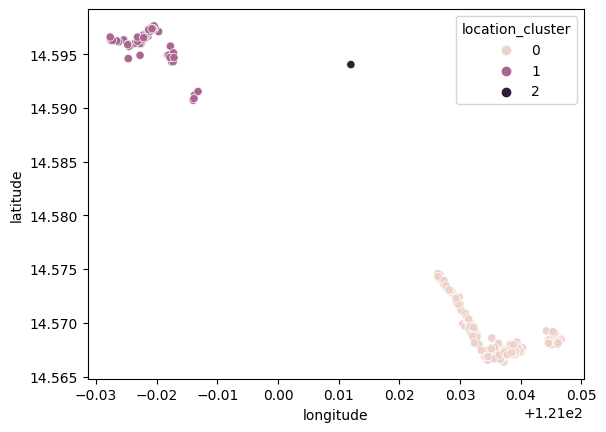

In [29]:
sns.scatterplot(combined_df, x='longitude', y='latitude', hue='location_cluster')

In [33]:
indexes = ['Mandaluyong Area (277 images)', 'Manila Area (82 images)', 'Middle Area']

values = []

for name, group in combined_df.groupby('location_cluster'):
    count = len(group)
    n_wh = group['objects_found'].apply(lambda x: 'wh' in x).sum()
    n_g = group['objects_found'].apply(lambda x: 'g' in x).sum()
    n_b = group['objects_found'].apply(lambda x: 'b' in x).sum()
    n_o = group['objects_found'].apply(lambda x: 'o' in x).sum()
    
    if(name != 2):
        values.append({
            'name': indexes[name],
            'total': count,
#             'water_hyacinths': round(n_wh / count * 100, 2),
#             'garbages': round(n_g / count * 100, 2),
#             'boats': round(n_b / count * 100, 2),
#             'others': round(n_o / count * 100, 2),
            'water_hyacinths': round(group['wh_relative_to_river'].mean() * 100, 4),
            'garbages': round(group['g_relative_to_river'].mean() * 100, 4),
            'boats': round(group['b_relative_to_river'].mean() * 100, 4),
            'others': round(group['o_relative_to_river'].mean() * 100, 4),
        })
    
values_df = pd.DataFrame(values)
values_df

,name,total,water_hyacinths,garbages,boats,others
0,Mandaluyong Area (277 images),277,0.5714,0.0322,1.1172,0.0080
1,Manila Area (82 images),82,0.5517,0.0670,0.3605,0.0039


Text(0, 0.5, '% of Images')

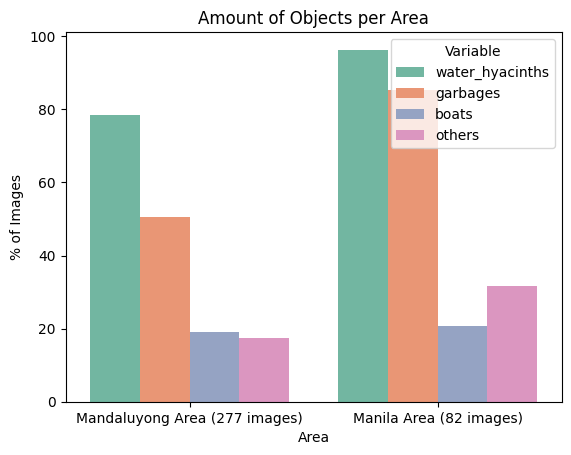

In [31]:
tidy = values_df[['name', 'water_hyacinths', 'garbages', 'boats', 'others']].melt(id_vars='name').rename(columns=str.title)

sns.barplot(x='Name', y='Value', hue='Variable', data=tidy, palette='Set2')

plt.title('Amount of Objects per Area')
plt.xlabel('Area')
plt.ylabel('% of Images')

Text(0, 0.5, '% of River Covered')

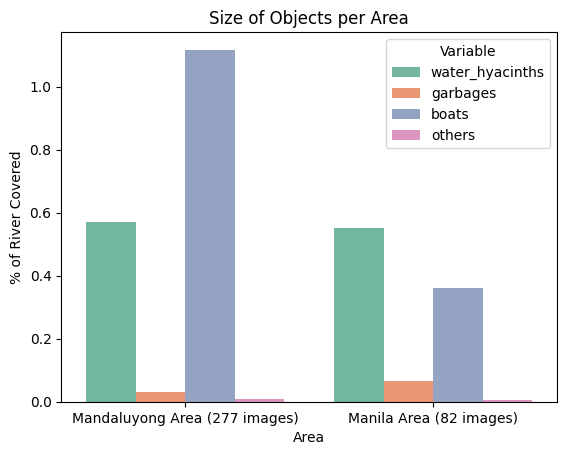

In [34]:
tidy = values_df[['name', 'water_hyacinths', 'garbages', 'boats', 'others']].melt(id_vars='name').rename(columns=str.title)

sns.barplot(x='Name', y='Value', hue='Variable', data=tidy, palette='Set2')

plt.title('Size of Objects per Area')
plt.xlabel('Area')
plt.ylabel('% of River Covered')

### Minimum Water Hyacinths

In [35]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   name                     360 non-null    object             
 1   height                   360 non-null    int64              
 2   width                    360 non-null    int64              
 3   area                     360 non-null    int64              
 4   river_area               360 non-null    float64            
 5   river_relative_to_image  360 non-null    float64            
 6   water_hyacinths          360 non-null    object             
 7   water_hyacinth_bounds    360 non-null    object             
 8   wh_count                 360 non-null    int64              
 9   garbage                  360 non-null    object             
 10  garbage_bounds           360 non-null    object             
 11  g_count                  360 non

In [36]:
min_index = None
min_wh_height = None
min_wh_width = None
min_area = 99999999999
for i, row in combined_df.iterrows():
    for bounds in row['water_hyacinth_bounds'].split('|'):
        try:
            x1, y1, x2, y2 = bounds.split(',')
            width = float(x2) - float(x1)
            height = float(y2) - float(y1) 
            area = width * height
            if(area < min_area):
                min_area = area
                min_index = i
                min_wh_width = width
                min_wh_height = height
        except:
            pass
            
print(min_index, min_area, min_wh_width, min_wh_height)

330 9.09680000000001 2.740000000000009 3.319999999999993


In [37]:
min_index = None
min_wh_height = None
min_wh_width = None
min_area = 99999999999
for i, row in combined_df.iterrows():
    for bounds in row['garbage_bounds'].split('|'):
        try:
            x1, y1, x2, y2 = bounds.split(',')
            width = float(x2) - float(x1)
            height = float(y2) - float(y1) 
            area = width * height
            if(area < min_area):
                min_area = area
                min_index = i
                min_wh_width = width
                min_wh_height = height
        except:
            pass
            
print(min_index, min_area, min_wh_width, min_wh_height)

299 9.000000000000057 3.6000000000000227 2.5


## Visualize

## RGB Analysis

### Water Hyacinths per Pixel

In [4]:
wh_rgb_df = pd.DataFrame(water_hyacinths_rgb)
wh_rgb_df.head()

,red,green,blue,hue,saturation,value
0,122,108,98,13,51,122
1,125,111,100,13,51,125
2,125,108,97,12,57,125
3,128,124,100,25,56,128
4,85,86,61,30,74,86


In [5]:
wh_rgb_df.describe()

,red,green,blue,hue,saturation,value
count,347968.000000,347968.000000,347968.000000,347968.000000,347968.000000,347968.000000
mean,83.303393,90.765734,76.195417,54.418021,77.667849,94.129742
std,50.495041,47.647679,50.931824,33.197658,58.674260,49.187437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,53.000000,33.000000,33.000000,28.000000,54.000000
50%,76.000000,85.000000,67.000000,46.000000,66.000000,88.000000
75%,123.000000,125.000000,115.000000,68.000000,113.000000,130.000000
max,255.000000,255.000000,255.000000,179.000000,255.000000,255.000000


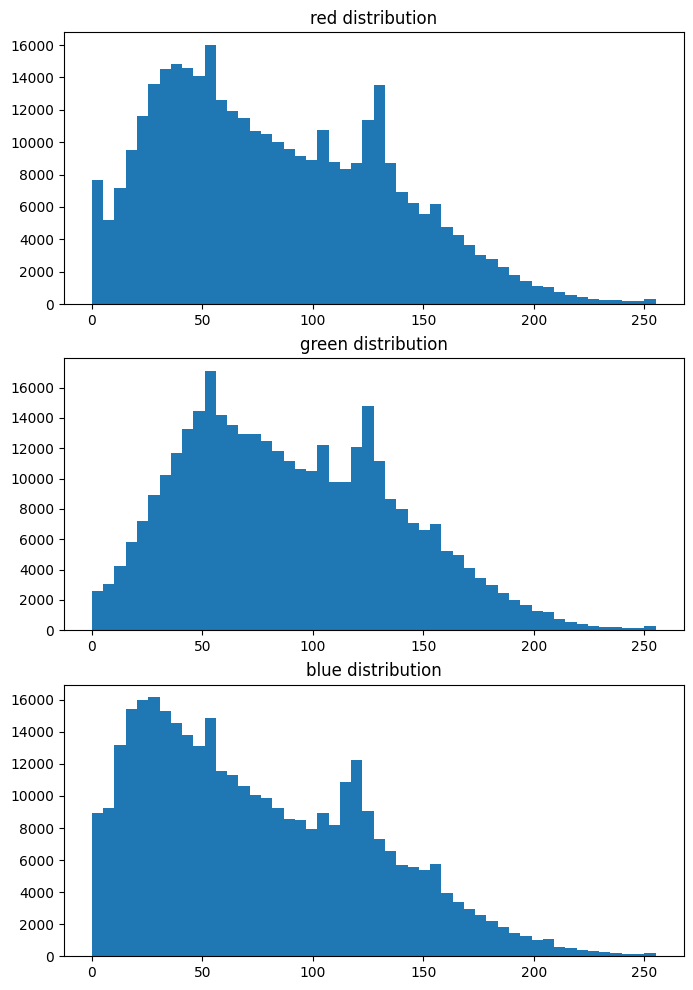

In [6]:
figs, axs = plt.subplots(3, figsize=(8,12))

axs[0].set_title('red distribution')
axs[0].hist(wh_rgb_df['red'], bins=50)

axs[1].set_title('green distribution')
axs[1].hist(wh_rgb_df['green'], bins=50)

axs[2].set_title('blue distribution')
axs[2].hist(wh_rgb_df['blue'], bins=50)

plt.show()

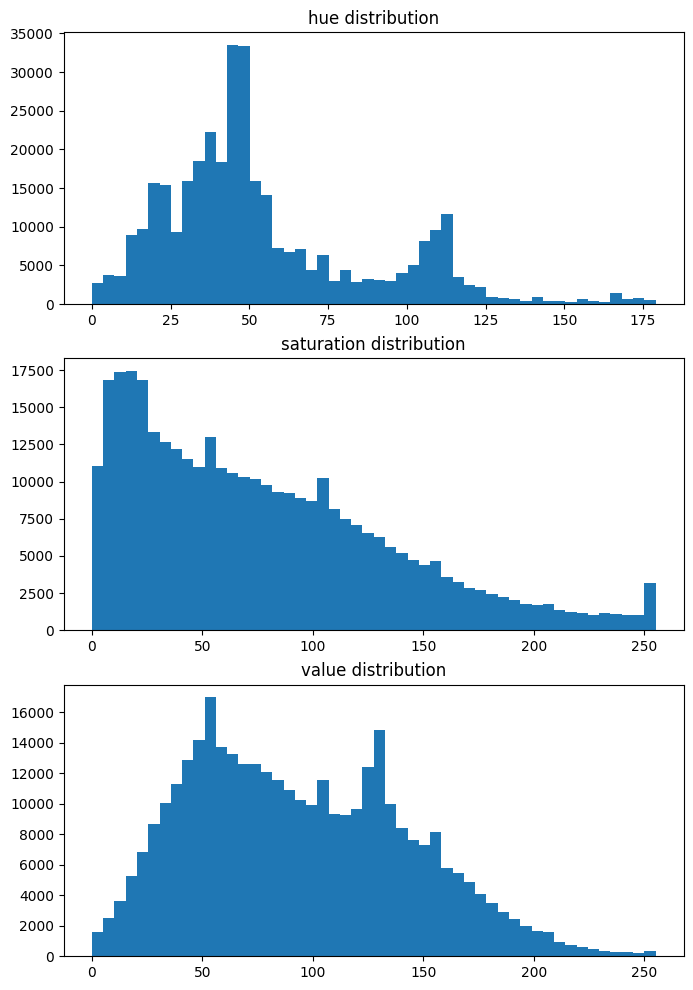

In [7]:
figs, axs = plt.subplots(3, figsize=(8, 12))

axs[0].set_title('hue distribution')
axs[0].hist(wh_rgb_df['hue'], bins=50)

axs[1].set_title('saturation distribution')
axs[1].hist(wh_rgb_df['saturation'], bins=50)

axs[2].set_title('value distribution')
axs[2].hist(wh_rgb_df['value'], bins=50)

plt.show()

In [8]:
sample_images = []
for im in images[354:360]:
    image = cv2.imread('./images/images/%s' % im['name'], cv2.IMREAD_COLOR)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_image = cv2.resize(hsv_image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
    image = cv2.resize(image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
    sample_images.append([image, hsv_image])
len(sample_images)

6

In [8]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('RMin','image',0,360,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('GMin','image',0,360,nothing)
cv2.createTrackbar('BMin','image',0,360,nothing)
cv2.createTrackbar('RMax','image',0,360,nothing)
cv2.createTrackbar('GMax','image',0,360,nothing)
cv2.createTrackbar('BMax','image',0,360,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('RMax', 'image', 360)
cv2.setTrackbarPos('GMax', 'image', 360)
cv2.setTrackbarPos('BMax', 'image', 360)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

waitTime = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('RMin','image')
    sMin = cv2.getTrackbarPos('GMin','image')
    vMin = cv2.getTrackbarPos('BMin','image')

    hMax = cv2.getTrackbarPos('RMax','image')
    sMax = cv2.getTrackbarPos('GMax','image')
    vMax = cv2.getTrackbarPos('BMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    output = []
    for rgb_img, _ in sample_images:
        mask = cv2.inRange(rgb_img, lower, upper)
        output.append(cv2.bitwise_and(rgb_img, rgb_img, mask=mask))

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image', np.concatenate((np.concatenate((output[0], output[1], output[2]), axis=1), np.concatenate((output[3], output[4], output[5]), axis=1)), axis=0))

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(waitTime) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 2 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 7 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 10 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 11 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 12 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 16 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 18 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 19 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 20 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 24 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 28 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 31 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 34 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 

(hMin = 30 , sMin = 0, vMin = 0), (hMax = 250 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 239 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 228 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 217 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 209 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 199 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 191 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 187 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 183 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 176 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 171 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 168 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 164 , sMax = 360, vMax = 360)
(hMin = 30 , sMin = 0, vMin = 0), (hMax = 163 , sMax = 360, vMax

(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 174)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 168)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 162)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 155)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 148)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 141)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 134)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 130)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 128)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 126)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 124)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 123)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 135, vMax = 124)
(hMin = 30 , sMin = 45, vMin = 25), (h

(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 105, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 106, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 108, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 109, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 110, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 111, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 112, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 113, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 114, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 115, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 116, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 117, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 130 , sMax = 118, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (h

(hMin = 30 , sMin = 45, vMin = 25), (hMax = 224 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 232 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 242 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 251 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 257 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 264 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 269 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 272 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 267 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 257 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 250 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 243 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 233 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (h

(hMin = 30 , sMin = 45, vMin = 25), (hMax = 64 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 65 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 66 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 67 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 68 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 69 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 70 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 71 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 70 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 69 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 68 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 66 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 64 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 61 , sM

(hMin = 30 , sMin = 45, vMin = 25), (hMax = 139 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 132 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 124 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 118 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 112 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 106 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 101 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 98 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 97 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 96 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 95 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 94 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 92 , sMax = 145, vMax = 100)
(hMin = 30 , sMin = 45, vMin = 25), (hMax = 

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2576: error: (-27:Null pointer) NULL window: 'image' in function 'cvGetTrackbarPos'


In [9]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,360,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,360,nothing)
cv2.createTrackbar('VMin','image',0,360,nothing)
cv2.createTrackbar('HMax','image',0,360,nothing)
cv2.createTrackbar('SMax','image',0,360,nothing)
cv2.createTrackbar('VMax','image',0,360,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 360)
cv2.setTrackbarPos('SMax', 'image', 360)
cv2.setTrackbarPos('VMax', 'image', 360)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

waitTime = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    output = []
    for _, hsv_img in sample_images:
        mask = cv2.inRange(hsv_img, lower, upper)
        output.append(cv2.bitwise_and(hsv_img, hsv_img, mask=mask))

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image', np.concatenate((np.concatenate((output[0], output[1], output[2]), axis=1), np.concatenate((output[3], output[4], output[5]), axis=1)), axis=0))

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(waitTime) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 1 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 2 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 6 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 10 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 14 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 16 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 17 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 20 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 22 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 24 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 27 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 29 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 360)
(hMin = 32 , sMin = 0, vMin = 0), (hMax = 360 , sMax = 360, vMax = 3

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2576: error: (-27:Null pointer) NULL window: 'image' in function 'cvGetTrackbarPos'


(hMin = 30 , sMin = 60, vMin = 0), (hMax = 360 , sMax = 360, vMax = 120)

### Garbage

In [10]:
garbage_rgb_df = pd.DataFrame(garbages_rgb)
garbage_rgb_df.head()

,red,green,blue,hue,saturation,value
0,112,107,113,145,14,113
1,194,194,200,121,7,200
2,231,231,237,125,6,237
3,166,154,151,6,23,166
4,169,160,158,5,17,169


In [12]:
garbage_rgb_df.describe()

,red,green,blue,hue,saturation,value
count,31645.000000,31645.000000,31645.000000,31645.000000,31645.000000,31645.000000
mean,126.518565,126.511360,125.670501,62.305419,44.698657,136.016780
std,59.592954,57.048255,54.186975,49.043535,51.885148,55.148903
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,83.000000,85.000000,87.000000,19.000000,9.000000,97.000000
50%,132.000000,128.000000,127.000000,39.000000,24.000000,140.000000
75%,168.000000,166.000000,161.000000,110.000000,60.000000,172.000000
max,255.000000,255.000000,255.000000,179.000000,255.000000,255.000000


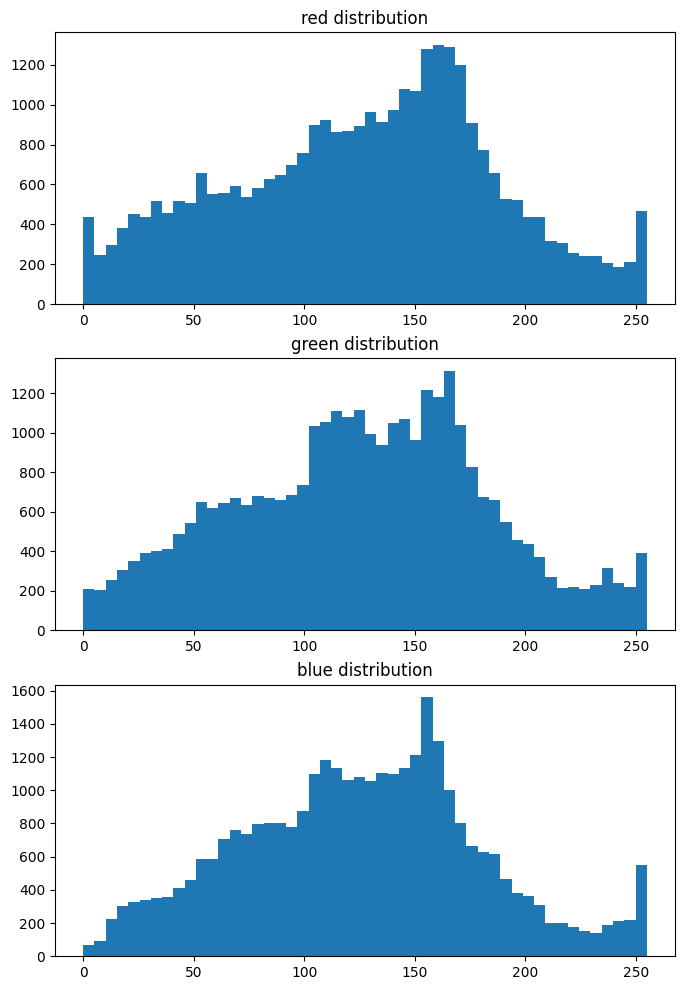

In [11]:
figs, axs = plt.subplots(3, figsize=(8,12))

axs[0].set_title('red distribution')
axs[0].hist(garbage_rgb_df['red'], bins=50)

axs[1].set_title('green distribution')
axs[1].hist(garbage_rgb_df['green'], bins=50)

axs[2].set_title('blue distribution')
axs[2].hist(garbage_rgb_df['blue'], bins=50)

plt.show()

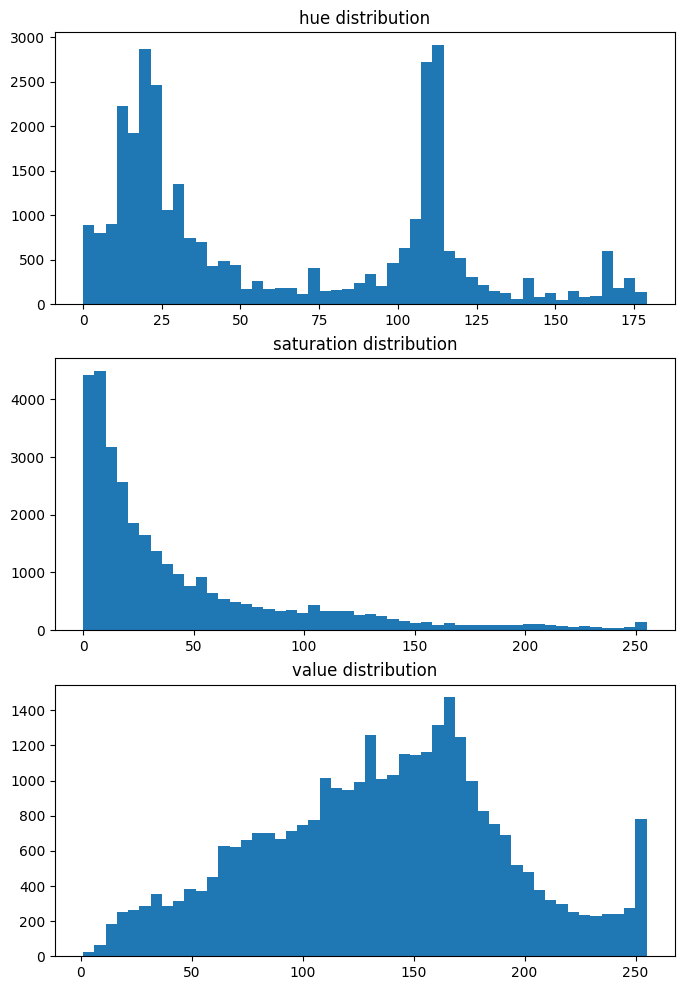

In [13]:
figs, axs = plt.subplots(3, figsize=(8, 12))

axs[0].set_title('hue distribution')
axs[0].hist(garbage_rgb_df['hue'], bins=50)

axs[1].set_title('saturation distribution')
axs[1].hist(garbage_rgb_df['saturation'], bins=50)

axs[2].set_title('value distribution')
axs[2].hist(garbage_rgb_df['value'], bins=50)

plt.show()